In [1]:
!pip install -q git+https://github.com/ibm-granite-community/utils \
    langchain-huggingface \
    langchain-milvus \
    replicate \
    wget

In [2]:
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_milvus import Milvus
from langchain.document_loaders import TextLoader
from langchain.text_splitter import SentenceTransformersTokenTextSplitter
from transformers import AutoTokenizer
import uuid
import os, wget

embeddings_checkpoint = "ibm-granite/granite-embedding-30m-english" 
embeddings_model = HuggingFaceEmbeddings(model_name=embeddings_checkpoint)
embeddings_tokenizer = AutoTokenizer.from_pretrained(embeddings_checkpoint)

/home/thangquang/CODE/multimodal-rag-baseline/env/lib/python3.10/site-packages/langchain_community/document_loaders/blob_loaders/file_system.py:6: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  from langchain_community.document_loaders.blob_loaders.schema import Blob, BlobLoader
/home/thangquang/CODE/multimodal-rag-baseline/env/lib/python3.10/site-packages/langchain_community/document_loaders/__init__.py:227: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 int

In [3]:
from docling.document_converter import DocumentConverter, PdfFormatOption
from docling.datamodel.base_models import InputFormat
from docling.datamodel.pipeline_options import PdfPipelineOptions

pdf_pipeline_options = PdfPipelineOptions(
    do_ocr=False,
    generate_picture_images=True
)

format_options = {
    InputFormat.PDF: PdfFormatOption(pipeline_options=pdf_pipeline_options)
}

converter = DocumentConverter(format_options=format_options)
sources = ["../data/raw/pdfs/659dfd3e5c22a64d7597cb50c6fc455e.pdf"]

conversions = {
    source: converter.convert(source).document for source in sources
}

In [4]:
from docling_core.transforms.chunker.hybrid_chunker import HybridChunker
from docling_core.types.doc.document import TableItem
from langchain_core.documents import Document

doc_id = 0
texts: list[Document] = []

for source, docling_document in conversions.items():
    for chunk in HybridChunker(tokenizer=embeddings_tokenizer).chunk(docling_document):
        items = chunk.meta.doc_items
        if len(items) == 1 and isinstance(items[0], TableItem):
            continue # process table later
        refs = " ".join(map(lambda item: item.get_ref().cref, items))
        print(refs)
        text = chunk.text
        document = Document(
            page_content=text,
            metadata={
                "doc_id": (doc_id:=doc_id+1),
                "source": source,
                "refs": refs,
            }
        )
        texts.append(document)
        
print(f"{len(texts)} chunks extracted")

Token indices sequence length is longer than the specified maximum sequence length for this model (781 > 512). Running this sequence through the model will result in indexing errors


#/texts/2 #/texts/3 #/texts/4 #/texts/5 #/texts/6 #/texts/7 #/texts/8 #/texts/9 #/texts/10 #/texts/11
#/texts/13 #/texts/14 #/texts/15
#/texts/17 #/texts/18 #/texts/19 #/texts/20 #/texts/21 #/texts/22 #/texts/23 #/texts/24 #/texts/25 #/texts/26 #/texts/27 #/texts/28 #/texts/29 #/texts/30 #/texts/31 #/texts/32 #/texts/33 #/texts/34 #/texts/35 #/texts/36 #/texts/37 #/texts/38
#/texts/39 #/texts/40
#/texts/42 #/texts/43 #/texts/44 #/texts/45 #/texts/46 #/texts/47 #/texts/48
#/texts/49 #/texts/50 #/texts/51 #/texts/52
#/texts/54 #/texts/55 #/texts/56
#/texts/58 #/texts/59 #/texts/60
#/texts/62 #/texts/63 #/texts/64 #/texts/65 #/texts/66 #/texts/67 #/texts/68 #/texts/69
#/texts/71 #/texts/72 #/texts/73
#/tables/0
#/tables/3
#/tables/4
#/tables/5 #/texts/79 #/texts/80 #/texts/81 #/texts/82 #/texts/83
#/tables/6
#/texts/86 #/texts/87
#/texts/89 #/texts/90 #/texts/91 #/texts/92 #/texts/93 #/texts/94 #/texts/95 #/texts/96
#/texts/97 #/texts/98 #/texts/99 #/texts/100 #/texts/101 #/texts/102 #/te

In [5]:
from docling_core.types.doc.labels import DocItemLabel

doc_id = len(texts)
tables: list[Document] = []
for source, docling_document in conversions.items():
    for table in docling_document.tables:
        if table.label in [DocItemLabel.TABLE]:
            ref = table.get_ref().cref
            print(ref)
            text = table.export_to_markdown()
            document = Document(
                page_content=text,
                metadata={
                    "doc_id": (doc_id:=doc_id+1),
                    "source": source,
                    "ref": ref,
                }
            )
            tables.append(document)
            
print(f"{len(tables)} tables extracted")

Usage of TableItem.export_to_markdown() without `doc` argument is deprecated.
Usage of TableItem.export_to_markdown() without `doc` argument is deprecated.
Usage of TableItem.export_to_markdown() without `doc` argument is deprecated.
Usage of TableItem.export_to_markdown() without `doc` argument is deprecated.
Usage of TableItem.export_to_markdown() without `doc` argument is deprecated.
Usage of TableItem.export_to_markdown() without `doc` argument is deprecated.
Usage of TableItem.export_to_markdown() without `doc` argument is deprecated.


#/tables/0
#/tables/1
#/tables/2
#/tables/3
#/tables/4
#/tables/5
#/tables/6
7 tables extracted


#/pictures/0


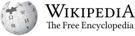

INFO:thangquang_01_image_caption:Sending Request
INFO:thangquang_01_image_caption:Time taken: 1.595665454864502 seconds


The Wikipedia logo, featuring a globe and the word "Wikipedia" in bold font, with the tagline "The Free Encyclopedia" underneath.
#/pictures/1


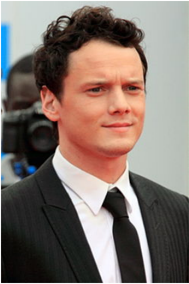

INFO:thangquang_01_image_caption:Sending Request
INFO:thangquang_01_image_caption:Time taken: 1.5272550582885742 seconds


Close-up shot of a man with short, curly brown hair. He's wearing a dark suit and tie, and has a slight smile on his face. The background is blurred, suggesting he's at an event or photoshoot.
#/pictures/2


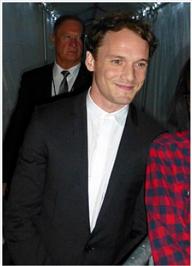

INFO:thangquang_01_image_caption:Sending Request
INFO:thangquang_01_image_caption:Time taken: 1.2392032146453857 seconds


A man in a black suit and white shirt smiles slightly as he walks through a hallway, flanked by a security guard.
#/pictures/3


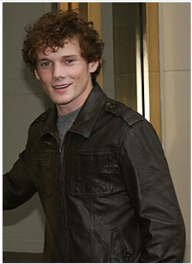

INFO:thangquang_01_image_caption:Sending Request
INFO:thangquang_01_image_caption:Time taken: 1.2880609035491943 seconds


A young man with curly brown hair and a slight smile is pictured wearing a black leather jacket. He appears to be standing in a doorway or hallway.
#/pictures/4


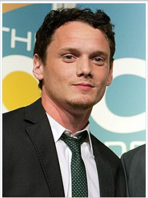

INFO:thangquang_01_image_caption:Sending Request
INFO:thangquang_01_image_caption:Time taken: 2.288849353790283 seconds


Headshot of actor Max Greenfield in a dark suit and green tie against a blurry background.
#/pictures/5


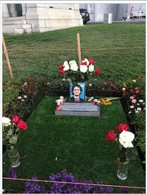

INFO:thangquang_01_image_caption:Sending Request
INFO:thangquang_01_image_caption:Time taken: 1.6943647861480713 seconds


A small, freshly planted grave is shown, adorned with red and white roses. A framed photo of a woman rests on the grave, surrounded by small potted plants. The setting appears to be a grassy area near a stone building.
#/pictures/6


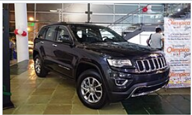

INFO:thangquang_01_image_caption:Sending Request
INFO:thangquang_01_image_caption:Time taken: 2.375025749206543 seconds


A dark-colored Jeep Grand Cherokee SUV is shown in a showroom. The vehicle is the main focus of the image, and it is positioned in the center. The setting appears to be indoors, likely a car dealership, with a polished floor and some background elements suggesting a modern retail space.
#/pictures/7


INFO:thangquang_01_image_caption:Sending Request
INFO:thangquang_01_image_caption:Time taken: 1.136488914489746 seconds


A stylized image depicting a red sun encircled by a blue, curved arrow, suggesting cyclical renewal or progress.
8 pictures extracted


In [6]:
from IPython.display import display
from thangquang_01_image_caption import generate_caption_with_gemini

pictures: list[Document] = []
doc_id = len(texts) + len(tables)
for source, docling_document in conversions.items():
    for picture in docling_document.pictures:
        ref = picture.get_ref().cref
        print(ref)
        image = picture.get_image(docling_document)
        display(image)
        if image is None:
            continue
        caption = generate_caption_with_gemini(image=image)
        print(caption)
        document = Document(
            page_content=caption,
            metadata={
                "doc_id": (doc_id:=doc_id+1),
                "source": source,
                "ref": ref,
            }
        )
        pictures.append(document)
        
print(f"{len(pictures)} pictures extracted")

Document ID: 1
Source: ../data/raw/pdfs/659dfd3e5c22a64d7597cb50c6fc455e.pdf
Page Content:
53 languages
Article
Talk
From Wikipedia, the free encyclopedia
Read
Edit
View history
Tools
In this name that follows East Slavic naming customs, the patronymic is Viktorovich and the family name is Yelchin .
Anton Viktorovich Yelchin (March 11, 1989 - June 19, 2016) was an American actor. Born in the Soviet Union to a Russian Jewish family, he immigrated to the United States with his parents at the age of six months. He began his career as a child actor, appearing as the lead of the mystery drama film Hearts in Atlantis (2001) and a series regular on the Showtime comedy-drama Huff (2004-2006). His fame grew when he guest-starred in a 2004 episode of Curb Your Enthusiasm .
--------------------------------------------------------------------------------
Document ID: 2
Source: ../data/raw/pdfs/659dfd3e5c22a64d7597cb50c6fc455e.pdf
Page Content:
Yelchin landed higher-profile film roles in 2009, port

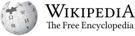

--------------------------------------------------------------------------------
Document ID: 34
Source: ../data/raw/pdfs/659dfd3e5c22a64d7597cb50c6fc455e.pdf
Page Content:
Close-up shot of a man with short, curly brown hair. He's wearing a dark suit and tie, and has a slight smile on his face. The background is blurred, suggesting he's at an event or photoshoot.
Image:


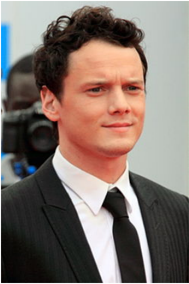

--------------------------------------------------------------------------------
Document ID: 35
Source: ../data/raw/pdfs/659dfd3e5c22a64d7597cb50c6fc455e.pdf
Page Content:
A man in a black suit and white shirt smiles slightly as he walks through a hallway, flanked by a security guard.
Image:


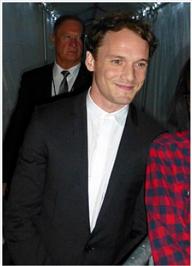

--------------------------------------------------------------------------------
Document ID: 36
Source: ../data/raw/pdfs/659dfd3e5c22a64d7597cb50c6fc455e.pdf
Page Content:
A young man with curly brown hair and a slight smile is pictured wearing a black leather jacket. He appears to be standing in a doorway or hallway.
Image:


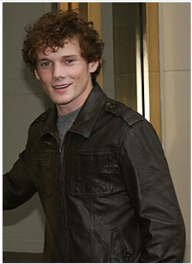

--------------------------------------------------------------------------------
Document ID: 37
Source: ../data/raw/pdfs/659dfd3e5c22a64d7597cb50c6fc455e.pdf
Page Content:
Headshot of actor Max Greenfield in a dark suit and green tie against a blurry background.
Image:


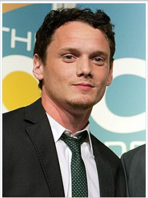

--------------------------------------------------------------------------------
Document ID: 38
Source: ../data/raw/pdfs/659dfd3e5c22a64d7597cb50c6fc455e.pdf
Page Content:
A small, freshly planted grave is shown, adorned with red and white roses. A framed photo of a woman rests on the grave, surrounded by small potted plants. The setting appears to be a grassy area near a stone building.
Image:


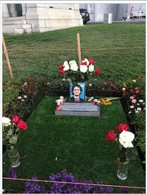

--------------------------------------------------------------------------------
Document ID: 39
Source: ../data/raw/pdfs/659dfd3e5c22a64d7597cb50c6fc455e.pdf
Page Content:
A dark-colored Jeep Grand Cherokee SUV is shown in a showroom. The vehicle is the main focus of the image, and it is positioned in the center. The setting appears to be indoors, likely a car dealership, with a polished floor and some background elements suggesting a modern retail space.
Image:


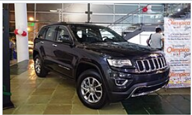

--------------------------------------------------------------------------------
Document ID: 40
Source: ../data/raw/pdfs/659dfd3e5c22a64d7597cb50c6fc455e.pdf
Page Content:
A stylized image depicting a red sun encircled by a blue, curved arrow, suggesting cyclical renewal or progress.
Image:


--------------------------------------------------------------------------------


In [31]:
import itertools
from docling_core.types.doc.document import RefItem

# print all created documents
for document in itertools.chain(texts, tables):
    print(f"Document ID: {document.metadata['doc_id']}")
    print(f"Source: {document.metadata['source']}")
    print(f"Page Content:\n{document.page_content}")
    print("-"*80)

for document in pictures:
    print(f"Document ID: {document.metadata['doc_id']}")
    source = document.metadata['source']
    print(f"Source: {source}")
    print(f"Page Content:\n{document.page_content}")
    docling_document = conversions[source]
    ref = document.metadata['ref']
    picture = RefItem(cref=ref).resolve(docling_document)
    image = picture.get_image(docling_document)
    print("Image:")
    display(image)
    print("-"*80)


In [ ]:
import tempfile
from langchain_core.vectorstores import VectorStore
from langchain_milvus import Milvus

db_file: VectorStore = tempfile.NamedTemporaryFile(prefix="vectorstore_", suffix=".db", delete=False).name
print(f"Vector store file: {db_file}")

vector_store = Milvus(
    # collection_name="multimodal_rag_baseline",
    embedding_function=embeddings_model,
    connection_args={"uri": db_file},
    auto_id=True,
    enable_dynamic_field=True,
    index_params={"index_type": "AUTOINDEX"}
)

Vector store file: /tmp/vectorstore_9qbpr5sv.db


In [9]:
documents = list(itertools.chain(texts, tables, pictures))
print(f"Total documents: {len(documents)}")

ids = vector_store.add_documents(documents)
print("Vector store created successfully")

Total documents: 40
Vector store created successfully


In [27]:
import re

query = "Which cast member played Kyle Reese and also played Pavel Chekov in three \"Star Trek\" films?"

def process_retrieved_documents(vector_store, query, conversions):
    results = []
    
    for doc in vector_store.as_retriever().invoke(query):
        if "ref" in doc.metadata:
            ref = doc.metadata["ref"]
            if "picture" in ref:
                # Handle image documents
                source = doc.metadata["source"]
                docling_document = conversions[source]
                picture = RefItem(cref=ref).resolve(docling_document)
                image = picture.get_image(docling_document)
                results.append((doc, image))
            else:
                # Handle text documents with ref
                results.append((doc, None))
        else:
            # Handle documents without ref metadata
            results.append((doc, None))
            
    return results

# Process and display results
for doc, image in process_retrieved_documents(vector_store, query, conversions):
    if image is not None:
        display(image)
    print(doc)
    print("-"*80)

page_content='Yelchin landed higher-profile film roles in 2009, portraying Pavel Chekov in the Star Trek reboot and Kyle Reese in Terminator Salvation . He reprised his role as Chekov in the sequels Star Trek Into Darkness (2013) and Star Trek Beyond (2016).
Yelchin frequently worked on independent and lower-profile films, headlining the romantic drama Like Crazy (2011), the 2011 remake of Fright Night , the supernatural thriller Odd Thomas (2013), the romance 5 to 7 (2014), the horror comedy Burying the Ex (2014), the neo-noir The Driftless Area (2015), and the horror thriller Green Room (2015). As a voice actor, he voiced Clumsy Smurf in the live-action Smurfs films (20112013) and the lead role James Lake Jr. on the Netflix animated series Trollhunters: Tales of Arcadia (2016-2018). He maintained an active career until his accidental death in mid-2016 when he was fatally injured by his SUV at the age of 27.
edit ]' metadata={'doc_id': 2, 'source': '../data/raw/pdfs/659dfd3e5c22a64d75

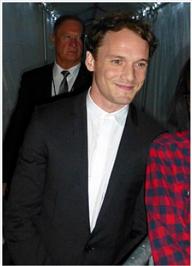

page_content='A man in a black suit and white shirt smiles slightly as he walks through a hallway, flanked by a security guard.' metadata={'doc_id': 35, 'source': '../data/raw/pdfs/659dfd3e5c22a64d7597cb50c6fc455e.pdf', 'ref': '#/pictures/2', 'pk': 457880255779307554}
--------------------------------------------------------------------------------


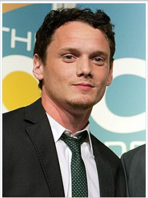

page_content='Headshot of actor Max Greenfield in a dark suit and green tie against a blurry background.' metadata={'doc_id': 37, 'source': '../data/raw/pdfs/659dfd3e5c22a64d7597cb50c6fc455e.pdf', 'ref': '#/pictures/4', 'pk': 457880255779307556}
--------------------------------------------------------------------------------


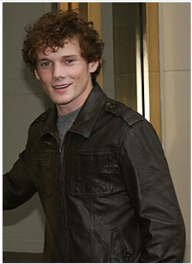

page_content='A young man with curly brown hair and a slight smile is pictured wearing a black leather jacket. He appears to be standing in a doorway or hallway.' metadata={'doc_id': 36, 'source': '../data/raw/pdfs/659dfd3e5c22a64d7597cb50c6fc455e.pdf', 'ref': '#/pictures/3', 'pk': 457880255779307555}
--------------------------------------------------------------------------------


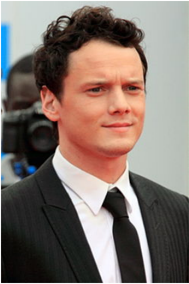

page_content='Close-up shot of a man with short, curly brown hair. He's wearing a dark suit and tie, and has a slight smile on his face. The background is blurred, suggesting he's at an event or photoshoot.' metadata={'doc_id': 34, 'source': '../data/raw/pdfs/659dfd3e5c22a64d7597cb50c6fc455e.pdf', 'ref': '#/pictures/1', 'pk': 457880255779307553}
--------------------------------------------------------------------------------


In [28]:
query = "What is the name of the main in black suit?"

for doc, image in process_retrieved_documents(vector_store, query, conversions):
    if image is not None:
        display(image)
    print(doc)
    print("-"*80)

Document ID: 1
Source: ../data/raw/pdfs/659dfd3e5c22a64d7597cb50c6fc455e.pdf
Page Content: 53 languages
Article
Talk
From Wikipedia, the free encyclopedia
Read
Edit
View history
Tools
In this name that follows East Slavic naming customs, the patronymic is Viktorovich and the family name is Yelchin .
Anton Viktorovich Yelchin (March 11, 1989 - June 19, 2016) was an American actor. Born in the Soviet Union to a Russian Jewish family, he immigrated to the United States with his parents at the age of six months. He began his career as a child actor, appearing as the lead of the mystery drama film Hearts in Atlantis (2001) and a series regular on the Showtime comedy-drama Huff (2004-2006). His fame grew when he guest-starred in a 2004 episode of Curb Your Enthusiasm .
--------------------------------------------------------------------------------
Document ID: 2
Source: ../data/raw/pdfs/659dfd3e5c22a64d7597cb50c6fc455e.pdf
Page Content: Yelchin landed higher-profile film roles in 2009, port

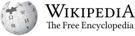

--------------------------------------------------------------------------------
Document ID: 34
Source: ../data/raw/pdfs/659dfd3e5c22a64d7597cb50c6fc455e.pdf
Page Content: Close-up shot of a man with short, curly brown hair. He's wearing a dark suit and tie, and has a slight smile on his face. The background is blurred, suggesting he's at an event or photoshoot.
Image:


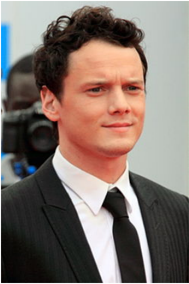

--------------------------------------------------------------------------------
Document ID: 35
Source: ../data/raw/pdfs/659dfd3e5c22a64d7597cb50c6fc455e.pdf
Page Content: A man in a black suit and white shirt smiles slightly as he walks through a hallway, flanked by a security guard.
Image:


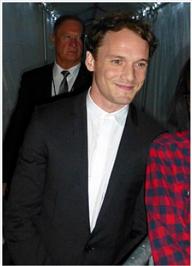

--------------------------------------------------------------------------------
Document ID: 36
Source: ../data/raw/pdfs/659dfd3e5c22a64d7597cb50c6fc455e.pdf
Page Content: A young man with curly brown hair and a slight smile is pictured wearing a black leather jacket. He appears to be standing in a doorway or hallway.
Image:


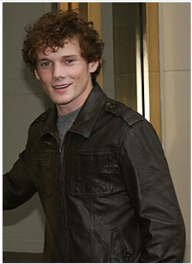

--------------------------------------------------------------------------------
Document ID: 37
Source: ../data/raw/pdfs/659dfd3e5c22a64d7597cb50c6fc455e.pdf
Page Content: Headshot of actor Max Greenfield in a dark suit and green tie against a blurry background.
Image:


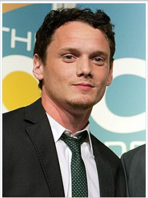

--------------------------------------------------------------------------------
Document ID: 38
Source: ../data/raw/pdfs/659dfd3e5c22a64d7597cb50c6fc455e.pdf
Page Content: A small, freshly planted grave is shown, adorned with red and white roses. A framed photo of a woman rests on the grave, surrounded by small potted plants. The setting appears to be a grassy area near a stone building.
Image:


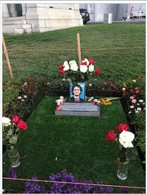

--------------------------------------------------------------------------------
Document ID: 39
Source: ../data/raw/pdfs/659dfd3e5c22a64d7597cb50c6fc455e.pdf
Page Content: A dark-colored Jeep Grand Cherokee SUV is shown in a showroom. The vehicle is the main focus of the image, and it is positioned in the center. The setting appears to be indoors, likely a car dealership, with a polished floor and some background elements suggesting a modern retail space.
Image:


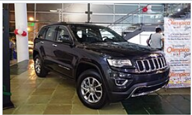

--------------------------------------------------------------------------------
Document ID: 40
Source: ../data/raw/pdfs/659dfd3e5c22a64d7597cb50c6fc455e.pdf
Page Content: A stylized image depicting a red sun encircled by a blue, curved arrow, suggesting cyclical renewal or progress.
Image:


--------------------------------------------------------------------------------


In [ ]:
import itertools
from docling_core.types.doc.document import RefItem

# print all created documents
for document in itertools.chain(texts, tables):
    print(f"Document ID: {document.metadata['doc_id']}")
    print(f"Source: {document.metadata['source']}")
    print(f"Page Content: {document.page_content}")
    print("-"*80)

for document in pictures:
    print(f"Document ID: {document.metadata['doc_id']}")
    source = document.metadata['source']
    print(f"Source: {source}")
    print(f"Page Content: {document.page_content}")
    docling_document = conversions[source]
    ref = document.metadata['ref']
    picture = RefItem(cref=ref).resolve(docling_document)
    image = picture.get_image(docling_document)
    print("Image:")
    display(image)
    print("-"*80)


In [29]:
query = "What is the title of the flim released in 2002?"

for doc, image in process_retrieved_documents(vector_store, query, conversions):
    if image is not None:
        display(image)
    print(doc)
    print("-"*80)

page_content='2000, Title = A Man Is Mostly Water. 2000, Role = Augie. 2000, Director = Fred Parnes. 2000, Notes = . 2001, Title = Delivering Milo. 2001, Role = Milo. 2001, Director = Nick Castle. 2001, Notes = . 2001, Title = 15 Minutes. 2001, Role = Boy in Burning Building. 2001, Director = John Herzfeld. 2001, Notes = . 2001, Title = Along Came a Spider. 2001, Role = Dimitri Starodubov. 2001, Director = Lee Tamahori. 2001, Notes = . 2001, Title = Hearts in Atlantis. 2001, Role = Bobby Garfield. 2001, Director = Scott Hicks. 2001, Notes = . 2002, Title = A Time for Dancing. 2002, Role = Jackson. 2002, Director = Peter Gilbert. 2002, Notes = ' metadata={'doc_id': 11, 'source': '../data/raw/pdfs/659dfd3e5c22a64d7597cb50c6fc455e.pdf', 'refs': '#/tables/0', 'pk': 457880255779307530}
--------------------------------------------------------------------------------
page_content='|   Year | Title                 | Role                    | Director      | Notes   |
|--------|----------------

Ở phần trên vẫn chưa thực hiện được truy vấn mà table liên trang, bởi vì trong PDF có phần Rooftop Kisses cũng vào năm 2002 nhưng nó bị cắt ngang